In [2]:
import os
import cv2
import json
import imutils
import numpy as np
import pandas as pd
from PIL import Image
from numpy import random
from matplotlib import pyplot as plt

import keras
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization, ZeroPadding2D, AveragePooling2D

In [3]:
def preprocess(im):
    
    im = im/128
    im -= 1
    return im.astype('float16')

In [4]:
def load_data_batch(ind, batch_size=None, channel=3, im_size=100, data_path='processed_data'):
    
    '''
        This function create a batch of training data
    '''
    
    label = json.load(open("{}/{}.json".format(data_path, ind)))   
    if not batch_size:
        batch_size = len(label)
    label = label[:batch_size]
    label = np.array(label).astype('float16').reshape((batch_size, 1))/30

    image_batch = np.zeros((batch_size, im_size, im_size, channel)).astype('float16')   
    for i in range(batch_size):
        
        im = Image.open("{}/{}/{}.png".format(data_path, ind, i))
        im = im.resize((im_size,im_size), Image.ANTIALIAS)
        im = np.array(im)
        image_batch[i] = preprocess(im).reshape((im_size, im_size, channel))
            
    return (image_batch, label)

In [14]:
x = [np.array([]) for i in range(9)]
y = [np.array([]) for i in range(9)]

for i in range(9):
    print(i)
    x[i], y[i] = load_data_batch(i, data_path = 'processed_data2')

x = np.concatenate(x)
y = np.concatenate(y)

0
1
2
3
4
5
6
7
8


In [13]:
del(x, y)

In [8]:
x_val, y_val = load_data_batch(9, 1000)

In [9]:
x.shape

(74394, 100, 100, 3)

In [10]:
model = keras.models.Sequential()

model.add(Conv2D(50, kernel_size=5, padding='same', strides=2, activation='relu', input_shape=(100,100,3)))
model.add(Dropout(0.3))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

#model.add(Conv2D(100, padding='same', kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(100, padding='same', kernel_size=3, strides=1, activation='relu'))
#model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(150, kernel_size=3, strides=2, activation='relu'))
model.add(Dropout(0.3))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

#model.add(Conv2D(200, kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(200, kernel_size=3, strides=2, activation='relu'))
#model.add(Conv2D(200, kernel_size=2, strides=2, activation='relu'))
model.add(Dropout(0.3))

#model.add(Conv2D(256, kernel_size=3, strides=1, activation='relu'))
#model.add(Conv2D(256, kernel_size=2, strides=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 50)        3800      
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 100)       45100     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 150)       135150    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 150)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 200)         2

In [17]:
adam = keras.optimizers.Adam(learning_rate=.0001)
model.compile(loss='mse',optimizer=adam, metrics=['mae'])

In [18]:
for i in range(9):

    model.fit(x[i*8266:(i+1)*8266], y[i*8266:(i+1)*8266], batch_size=64, epochs=1, validation_data=(x_val, y_val))

130/130 [==============================] - 74s 567ms/step - loss: 0.0626 - mae: 0.1664 - val_loss: 0.0611 - val_mae: 0.1518


In [19]:
model.save('angle.model')

INFO:tensorflow:Assets written to: angle.model\assets


In [29]:
(x_val[102]+.5).shape

(100, 100, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


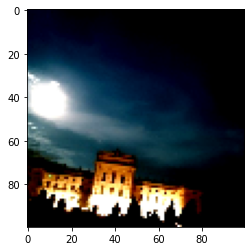

12.40725427865982

In [56]:
i = 0
plt.imshow(x_val[i].astype('float64')+.5)
plt.show()
a = model.predict(x_val[i].reshape((1,100,100,3)))
a[0][0]*30

In [54]:
y_val[i][0]*30

9.5361328125

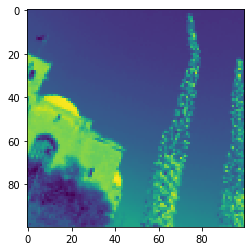

In [24]:
plt.imshow((x_val[3].astype('float64')), interpolation='nearest')
plt.show()

In [57]:
np.min(x_val[0])

-0.992

In [6]:


root_dir = 'raw_data'


def center_crop(img, dim):
    """Returns center cropped image
    Args:
    img: image to be center cropped
    dim: dimensions (width, height) to be cropped
    """
    width, height = img.shape[1], img.shape[0]

    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img


def get_random_angle():
    x = (random.rand()-0.5)*60
    return x


def rotate(image, angle):
    rotated = imutils.rotate_bound(image, angle)
    return rotated


def resize(image, shape, interpolation = cv2.INTER_CUBIC):
    resized = cv2.resize(image, (shape,shape))
    return resized


def process_imgs(i, out_dir):

    print("processoing folder: {}\n".format(i))
    inp_dir = "{}/{}".format(root_dir, i)
    out_dir = '{}/{}'.format(out_dir, i)
    os.system("mkdir -p {}".format(out_dir))
    ind = 0
    label = []
    final_shape = 100
    for folder in os.listdir(inp_dir):
        for img in os.listdir("{}/{}".format(inp_dir, folder)):
            image = cv2.imread("{}/{}/{}".format(inp_dir, folder, img))
            min_length = min(image.shape[0], image.shape[1])
            crop = center_crop(image, (min_length, min_length))
            angle = get_random_angle()
            rotated = rotate(crop, angle)
            rot_size = rotated.shape[0]
            deg_angle = abs((np.pi/180)*angle)
            crop_size = int(rot_size/(1+2*(np.sin(deg_angle))*(np.cos(deg_angle))))
            #plt.imshow((rotated))
            #plt.show()
            crop2 = center_crop(rotated, (crop_size, crop_size))
            #plt.imshow((crop2))
            #plt.show()
            resized = resize(crop2, final_shape)
            #plt.imshow((resized))
            #plt.show()
            label.append(angle)
            cv2.imwrite("{}/{}.png".format(out_dir, ind), resized)
            ind = ind+1
            if ind%1000==0:
                print("{} images done".format(ind))

    label = [round(i, 2) for i in label]
    json.dump(label, open("{}.json".format(out_dir), 'w'))

In [7]:
for d in ['processed_data', 'processed_data2']:
    for i in range(10):
        process_imgs(i, d)

processoing folder: 0

1000 images done
2000 images done
3000 images done
4000 images done
5000 images done
6000 images done
7000 images done
8000 images done
processoing folder: 1

1000 images done
2000 images done
3000 images done
4000 images done
5000 images done
6000 images done
7000 images done
8000 images done
processoing folder: 2

1000 images done
2000 images done
3000 images done
4000 images done
5000 images done
6000 images done
7000 images done
8000 images done
processoing folder: 3

1000 images done
2000 images done
3000 images done
4000 images done
5000 images done
6000 images done
7000 images done
8000 images done
processoing folder: 4

1000 images done
2000 images done
3000 images done
4000 images done
5000 images done
6000 images done
7000 images done
8000 images done
processoing folder: 5

1000 images done
2000 images done
3000 images done
4000 images done
5000 images done
6000 images done
7000 images done
8000 images done
processoing folder: 6

1000 images done
2000 i